#### Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import (RandomizedSearchCV, train_test_split,)

#### Import the dataset

In [ ]:
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y = True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
stats.randint.rvs(1,5)

1

In [ ]:
stats.uniform.rvs(0,1)

0.312111690499715

#### Random Search

In [ ]:
gbm = GradientBoostingClassifier(random_state=42)

param_grid = dict(
    n_estimators=stats.randint(10, 120),
    min_samples_split=stats.uniform(0,1),
    max_depth=stats.randint(1,5),
    loss=('deviance', 'exponential'),
)

In [ ]:
search = RandomizedSearchCV(gbm,
                            param_grid,
                            scoring='roc_auc',
                            cv=5,
                            n_iter=60,
                            random_state=10,
                            n_jobs=4,
                            refit=True)

search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=60, n_jobs=4,
                   param_distributions={'loss': ('deviance', 'exponential'),
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d4940e154b0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d4940e149d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d4940e14730>},
                   random_state=10, scoring='roc_auc')

In [ ]:
search.best_params_

{'loss': 'deviance',
 'max_depth': 4,
 'min_samples_split': 0.5655070198881675,
 'n_estimators': 92}

In [ ]:
results = pd.DataFrame(search.cv_results_)
results.sort_values(by='mean_test_score', ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)
results[['param_max_depth', 'param_min_samples_split', 'param_n_estimators', 'mean_test_score', 'std_test_score',]].head()

,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score
0,4,0.565507,92,0.989199,0.009336
1,3,0.534558,99,0.989198,0.010151
2,2,0.090459,90,0.989066,0.010616
3,3,0.140576,117,0.988673,0.009283
4,4,0.563191,88,0.988516,0.009729


In [ ]:
results[['param_max_depth', 'param_min_samples_split', 'param_n_estimators', 'mean_test_score', 'std_test_score',]].tail()

,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score
55,2,0.821106,21,0.977291,0.019176
56,3,0.714576,23,0.977144,0.019076
57,2,0.820704,10,0.976817,0.017766
58,4,0.781949,18,0.976693,0.019518
59,1,0.10462,10,0.976556,0.016969


Text(0.5, 0, 'Hyperparameter combinations')

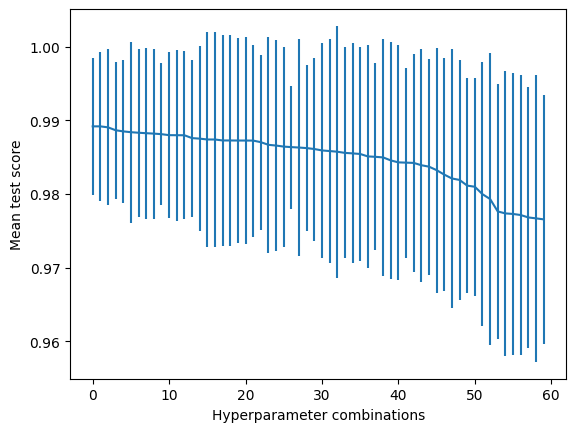

In [ ]:
results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

In [ ]:
X_train_preds = search.predict(X_train)
X_test_preds = search.predict(X_test)

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))

Train roc_auc:  1.0
Test roc_auc:  0.9497354497354498


In [ ]:
def summarize_by_param(hparam):

  tmp = pd.concat([
      results.groupby(hparam)['mean_test_score'].mean(),
      results.groupby(hparam)['mean_test_score'].std(),
  ], axis=1)

  tmp.columns = ['mean_test_score', 'std_test_score']

  return tmp

In [ ]:
tmp = summarize_by_param('param_n_estimators')

tmp.head()

,mean_test_score,std_test_score
param_n_estimators,,
10,0.976687,0.000185
14,0.977632,NaN
16,0.979319,NaN
17,0.980988,NaN
18,0.978335,0.002323


Text(0, 0.5, 'roc-auc')

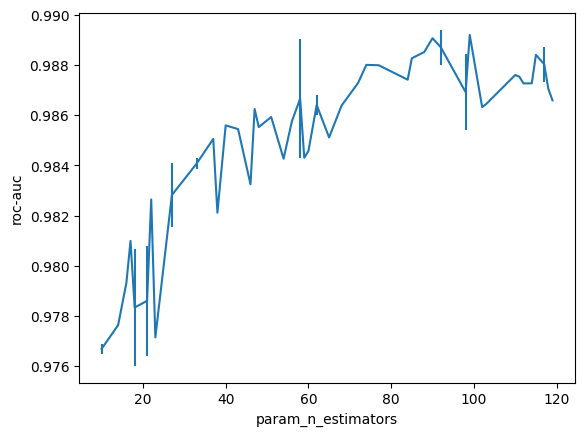

In [ ]:
tmp['mean_test_score'].plot(yerr=[tmp['std_test_score'], tmp['std_test_score']], subplots=True)
plt.ylabel('roc-auc')

Text(0, 0.5, 'roc-auc')

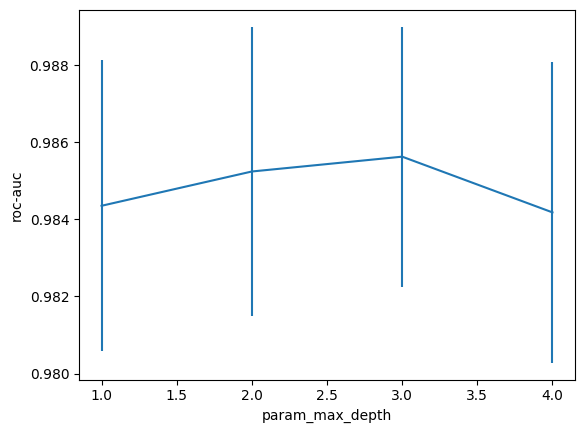

In [ ]:
tmp = summarize_by_param('param_max_depth')
tmp['mean_test_score'].plot(yerr=[tmp['std_test_score'], tmp['std_test_score']], subplots=True)
plt.ylabel('roc-auc')

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


Text(0, 0.5, 'roc-auc')

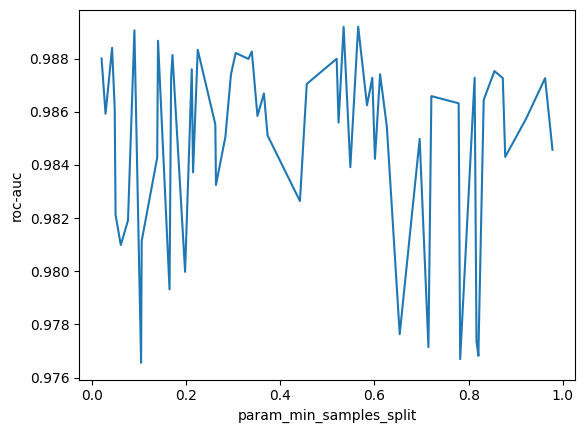

In [ ]:
tmp = summarize_by_param('param_min_samples_split')
tmp['mean_test_score'].plot(yerr=[tmp['std_test_score'], tmp['std_test_score']], subplots=True)
plt.ylabel('roc-auc')

(0.97, 1.0)

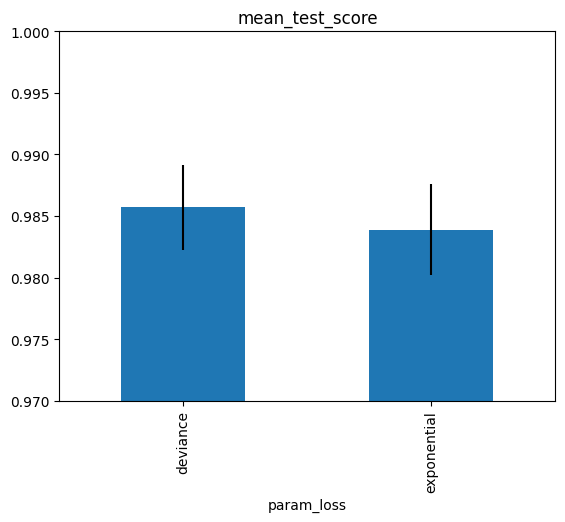

In [ ]:
tmp = summarize_by_param('param_loss')
tmp['mean_test_score'].plot.bar(yerr=[tmp['std_test_score'], tmp['std_test_score']], subplots=True)
plt.ylim(0.97, 1)